# Point Precision Using Residuals
@author: Max Felius


In [1]:
#imports
import numpy as np
import matplotlib.pyplot as plt
import os, sys, time, datetime, re
import pandas as pd

In [2]:
folder = 'data'
filename = 't37_points_d100_test_subset.csv'
image_folder = 'images'

data = pd.read_csv(os.path.join(folder,filename))

In [3]:
'''
Functions that are used
'''
def get_delta_day(epochs):
    dates = list(map(lambda x: datetime.datetime.strptime(x,'d_%Y%m%d'),epochs))
    start_date = dates[0]
    dates_days = np.array(list(map(lambda x: (x-start_date).days,dates)))

    return dates_days, start_date

def get_sentinel_epochs(data):
    '''
    data: pandas dataframe
    
    code to filter the epoch headers out of the dataset
    '''
    
    filter_string = re.compile(r'd_\d{8}')
    epochs = list(filter(lambda x: filter_string.match(x) != None, list(data)))
    
    return epochs

def linear_model(epochs,data):
    '''
    data: pandas dataframe (column which are not epochs can stay in the df)
    
    Function creating the linear model for detect arcs behaving anomalous
    '''
    
    #creating time vector
    delta_days, start_day = get_delta_day(epochs)
    
    #pre-allocate space for the output variables
    a = []
    b = []
    sigma_ehat = []
    ehat_out = {}
    
    for i in range(len(data)):
        '''
        Loop creating a linear model per row
        '''
        
        #setting up the system of equations
        y = np.array(data[epochs].iloc[i])
        A = np.array((delta_days,np.ones([len(delta_days)])))
        
        #stochastic matrix
        W = np.eye((len(y)))
        
        #compute solutions
        invW = np.linalg.inv(W)
        Qxhat = np.linalg.inv(A @ invW @ A.T)
        xhat = Qxhat @ A @ invW @ y
        
        yhat = A.T @ xhat
        ehat = y - yhat
        
        #compute the standard deviation of the noise of an arc
        sigma_ehat_out = np.sqrt((np.sum((ehat - np.mean(ehat))**2))/len(y))
        
        #saving the data
        a.append(xhat[0])
        b.append(xhat[1])
        sigma_ehat.append(sigma_ehat_out)
        ehat_out[str(i)] = ehat
    
    return a, b, sigma_ehat, ehat_out

def gcurve(mu,std,x):
    return (1/(std*np.sqrt(2*np.pi)))*np.exp(-(((x-mu)**2)/(2*std**2)))

In [4]:
'''
Creating the figure parameters
'''
epochs = get_sentinel_epochs(data)
a, b, sigma_ehat, ehat_model = linear_model(epochs,data)

delta_days = get_delta_day(epochs)

#location
i = 10
conf_int = 1.96 #95%

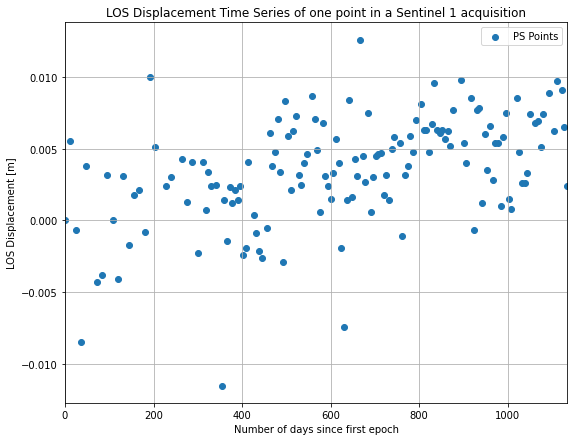

In [5]:
#figure with the deformation time series

fig, ax = plt.subplots(figsize=(9,7))

ax.scatter(delta_days[0],data[epochs].iloc[i].values,label='PS Points')

#Block of code to implement the figure settings
ax.set_xlim([0,delta_days[0][-1]])
ax.set_title('LOS Displacement Time Series of one point in a Sentinel 1 acquisition')
ax.set_ylabel('LOS Displacement [m]')
ax.set_xlabel('Number of days since first epoch')
ax.legend()
ax.grid(True);

fig.savefig(os.path.join(image_folder,'Deformation_TimeSeries.png'));

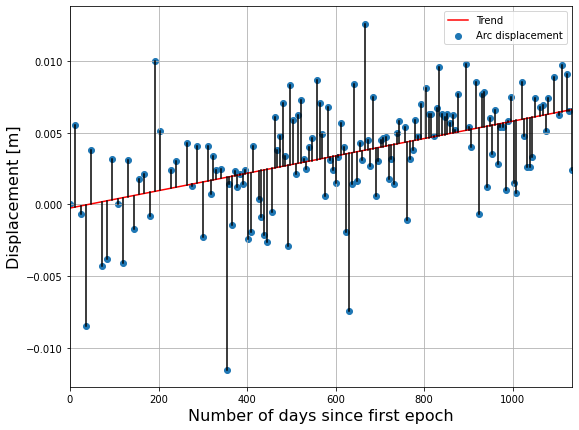

In [6]:
#Figure with trend and confidence intervals
fig, ax = plt.subplots(figsize=(9,7))

# plt.rcParams.update({'font.size': 12})

ax.scatter(delta_days[0],data[epochs].iloc[i].values,label='Arc displacement')
ax.plot(delta_days[0],a[i]*delta_days[0]+b[i],c='r',label='Trend')
# ax.plot(delta_days[0],a[i]*delta_days[0]+b[i]+conf_int*sigma_ehat[i],c='r',linestyle='dashed',label='95% Confidence Interval')
# ax.plot(delta_days[0],a[i]*delta_days[0]+b[i]-conf_int*sigma_ehat[i],c='r',linestyle='dashed')

#Block of code to implemtent line to show sigma
#taking day with index 30
iday = 30
# ax.annotate('',xy=(delta_days[0][iday], a[i]*delta_days[0][iday]+b[i]),
#             xytext=(delta_days[0][iday], a[i]*delta_days[0][iday]+b[i]+conf_int*sigma_ehat[i]),
#            arrowprops=dict(arrowstyle= '<|-|>',
#                              color='black'))
# ax.annotate(f'{conf_int}$\cdot \sigma$',xy=(delta_days[0][iday], a[i]*delta_days[0][iday]+b[i]+0.5*conf_int*sigma_ehat[i]))
data_used = data[epochs].iloc[i].values

for i_select in range(len(data_used)):
    x1 = delta_days[0][i_select]
    x2 = delta_days[0][i_select]
    y1 = data_used[i_select]
    y2 = a[i]*delta_days[0][i_select]+b[i]
    ax.plot([x1,x2],[y1,y2],c='k')


#Block of code to implement the figure settings
ax.set_xlim([0,delta_days[0][-1]])
ax.set_ylabel('Displacement [m]',fontsize=16)
ax.set_xlabel('Number of days since first epoch',fontsize=16)
ax.legend()
ax.grid(True);

fig.savefig(os.path.join(image_folder,'Deformation_TimeSeries_ConfInt_no_arrow.png'));

In [7]:
# yhist

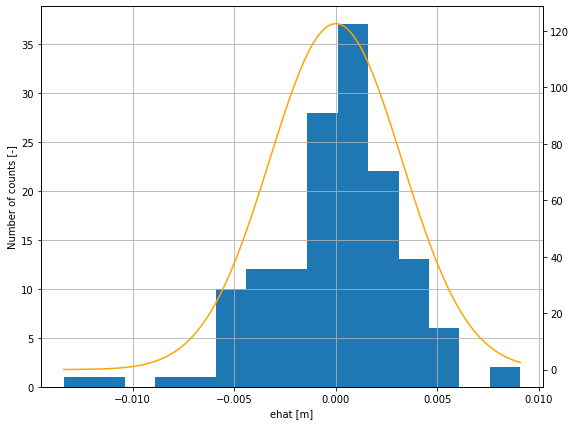

In [8]:
fig, ax = plt.subplots(figsize=(9,7))
ax.hist(ehat_model[str(i)],bins=15)

#plotting the gaussian curve
mu = np.mean(ehat_model[str(i)])
sigma = np.std(ehat_model[str(i)])
xhist = np.linspace(min(ehat_model[str(i)]),max(ehat_model[str(i)]),100)
yhist = gcurve(mu,sigma,xhist)

ax2 = ax.twinx()
ax2.plot(xhist,yhist,c='orange')

ax.set_ylabel('Number of counts [-]')
ax.set_xlabel('ehat [m]')
ax.grid(True)

fig.savefig(os.path.join(image_folder,'Simple_Histogram.png'));

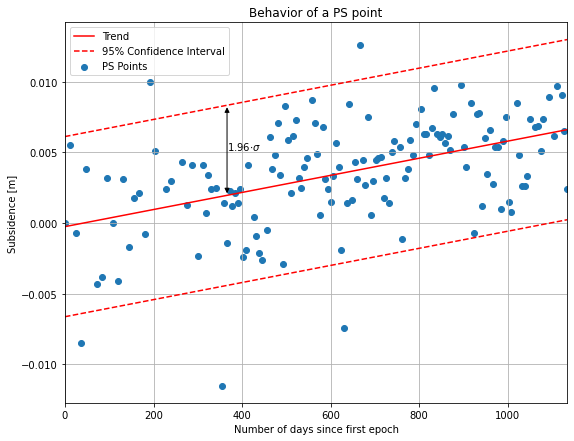

In [9]:
fig, ax = plt.subplots(nrows =1, ncols=1,figsize=(9,7))

ax.scatter(delta_days[0],data[epochs].iloc[i].values,label='PS Points')
ax.plot(delta_days[0],a[i]*delta_days[0]+b[i],c='r',label='Trend')
ax.plot(delta_days[0],a[i]*delta_days[0]+b[i]+conf_int*sigma_ehat[i],c='r',linestyle='dashed',label='95% Confidence Interval')
ax.plot(delta_days[0],a[i]*delta_days[0]+b[i]-conf_int*sigma_ehat[i],c='r',linestyle='dashed')

#Block of code to implemtent line to show sigma
#taking day with index 30
iday = 30
ax.annotate('',xy=(delta_days[0][iday], a[i]*delta_days[0][iday]+b[i]),
            xytext=(delta_days[0][iday], a[i]*delta_days[0][iday]+b[i]+conf_int*sigma_ehat[i]),
           arrowprops=dict(arrowstyle= '<|-|>',
                             color='black'))
ax.annotate(f'{conf_int}$\cdot \sigma$',xy=(delta_days[0][iday], a[i]*delta_days[0][iday]+b[i]+0.5*conf_int*sigma_ehat[i]))



#Block of code to implement the figure settings
ax.set_title('Behavior of a PS point')
ax.set_xlim([0,delta_days[0][-1]])
ax.set_ylabel('Subsidence [m]')
ax.set_xlabel('Number of days since first epoch')
ax.legend()
ax.grid(True);

fig.savefig(os.path.join(image_folder,'Deformation_TimeSeries_ConfInt.png'));

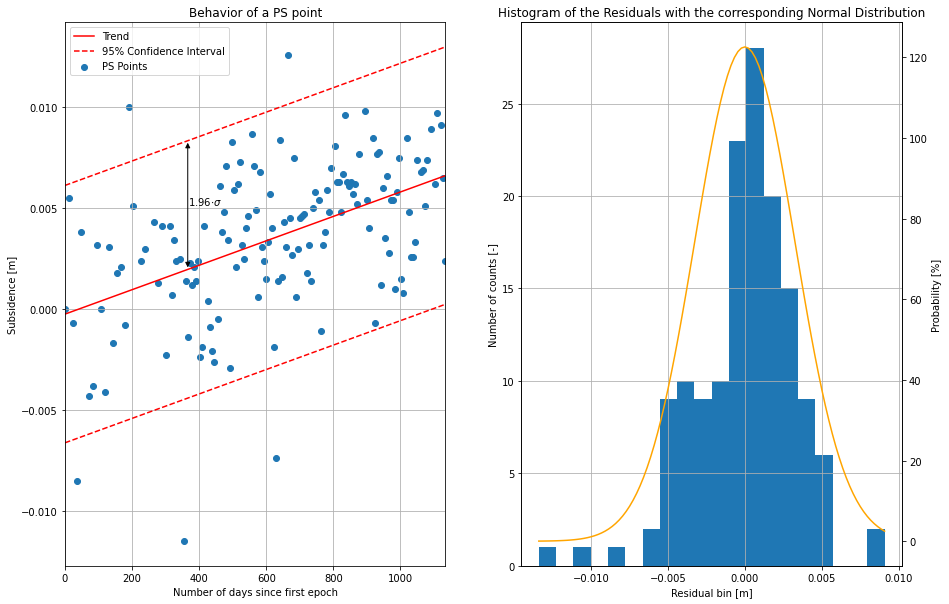

In [11]:
# #location
# i = 6
# conf_int = 1.96 #95%

fig, ax = plt.subplots(nrows =1, ncols=2,figsize=(15,10))

ax[0].scatter(delta_days[0],data[epochs].iloc[i].values,label='PS Points')
ax[0].plot(delta_days[0],a[i]*delta_days[0]+b[i],c='r',label='Trend')
ax[0].plot(delta_days[0],a[i]*delta_days[0]+b[i]+conf_int*sigma_ehat[i],c='r',linestyle='dashed',label='95% Confidence Interval')
ax[0].plot(delta_days[0],a[i]*delta_days[0]+b[i]-conf_int*sigma_ehat[i],c='r',linestyle='dashed')

#Block of code to implemtent line to show sigma
#taking day with index 30
iday = 30
ax[0].annotate('',xy=(delta_days[0][iday], a[i]*delta_days[0][iday]+b[i]),
            xytext=(delta_days[0][iday], a[i]*delta_days[0][iday]+b[i]+conf_int*sigma_ehat[i]),
           arrowprops=dict(arrowstyle= '<|-|>',
                             color='black'))
ax[0].annotate(f'{conf_int}$\cdot \sigma$',xy=(delta_days[0][iday], a[i]*delta_days[0][iday]+b[i]+0.5*conf_int*sigma_ehat[i]))



#Block of code to implement the figure settings
ax[0].set_title('Behavior of a PS point')
ax[0].set_xlim([0,delta_days[0][-1]])
ax[0].set_ylabel('Subsidence [m]')
ax[0].set_xlabel('Number of days since first epoch')
ax[0].legend()
ax[0].grid(True);

# fig.savefig('Noise_Determination.png');

#histogram of the points
ax[1].hist(ehat_model[str(i)],bins=20)

#plotting the gaussian curve
mu = np.mean(ehat_model[str(i)])
sigma = np.std(ehat_model[str(i)])

#parameters for plotting the Gaussian curve
xhist = np.linspace(min(ehat_model[str(i)]),max(ehat_model[str(i)]),100)
yhist = gcurve(mu,sigma,xhist)

#create secondairy axis
ax2 = ax[1].twinx()
ax2.plot(xhist,yhist,c='orange')
ax2.set_ylabel('Probability [%]')

ax[1].set_title('Histogram of the Residuals with the corresponding Normal Distribution')
ax[1].set_ylabel('Number of counts [-]')
ax[1].set_xlabel('Residual bin [m]')
ax[1].grid(True)

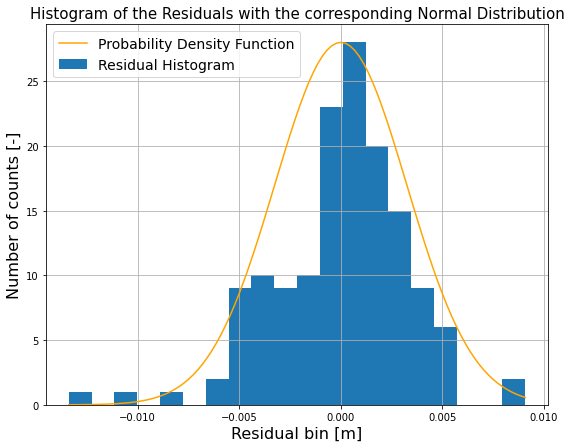

In [14]:
num_bins = 20

fig, ax = plt.subplots(figsize=(9,7))

h = ax.hist(ehat_model[str(i)],bins=num_bins,label='Residual Histogram')

#plotting the gaussian curve
mu = np.mean(ehat_model[str(i)])
sigma = np.std(ehat_model[str(i)])

#parameters for plotting the Gaussian curve
xhist = np.linspace(min(ehat_model[str(i)]),max(ehat_model[str(i)]),100)
yhist = gcurve(mu,sigma,xhist)

#plot curve
yhist2 = yhist/max(yhist)
yhist3 = yhist2*max(h[0])

ax.plot(xhist,yhist3,c='orange',label='Probability Density Function')
#create secondairy axis
# ax2 = ax.twinx()
# ax2.plot(xhist,yhist,c='orange')
# ax2.set_ylabel('Probability [%]')

ax.set_title('Histogram of the Residuals with the corresponding Normal Distribution',fontsize=15)
ax.set_ylabel('Number of counts [-]',fontsize=16)
ax.set_xlabel('Residual bin [m]',fontsize=16)
ax.grid(True)
ax.legend(fontsize=14);

fig.savefig(os.path.join(image_folder,'Histrogram_w_GaussianCurve.png'));